# Visualizing Overfitting and Model Complexity

In [1]:
%load_ext autoreload
%autoreload 2

import sys

from dataclasses import dataclass
from typing import Union

from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error
from AppliedML.courselib.utils.preprocessing import labels_encoding
from AppliedML.courselib.utils.splits import train_test_split
from AppliedML.courselib.optimizers import GDOptimizer
import AppliedML.courselib.models.nn as nn
import AppliedML.courselib.models.svm as svm
import datagen.ConcentricBands as cc
import datagen.HalfMoons as hm
import datagen.Spirals as sp
import datagen.SeparatedBlobs as sb
import datagen.Postprocessors as pp

from models.TunableModel import TunableModel
from models.TunableNN import TunableNN
from models.TunableKernelSVM import TunableKernelSVM
from models.TunableRandomForest import TunableRandomForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
@dataclass
class ExperimentConfig:
    tunable_model: TunableModel
    train_df: pd.DataFrame
    test_df: pd.DataFrame
    training_params: Union[dict, callable]
    title_generator: callable
    encode_label: callable
    measure_accuracy: callable
    random_seed: int

In [3]:
def train_tunable_model(cf):
    np.random.seed(cf.random_seed)
    
    models = cf.tunable_model.fit(
        X = cf.train_df[['x', 'y']].to_numpy(),
        y = cf.encode_label(cf.train_df['label']),
        training_params = cf.training_params,
    )

    models = [{"i": i, "model": model, "params": params, "metrics_hist": metrics_hist} 
              for i, model, params, metrics_hist in models]
    models.sort(key=lambda model: model["i"])

    for model in models:
        model["acc_train"] = cf.measure_accuracy(model["model"], cf.train_df)
        model["acc_test"] = cf.measure_accuracy(model["model"], cf.test_df)
    
    has_metrics = len([model["metrics_hist"] for model in models if model["metrics_hist"] is not None]) > 0
    if not has_metrics:
        return models
    
    fig, axs = plt.subplots(1, len(models), figsize=(8*len(models), 8))
    if len(models) == 1:
        axs = np.array([axs])
        
    for ax, model in zip(axs.flat, models):
        ax.set_title(cf.title_generator(model["params"]))

        metrics_hist = model["metrics_hist"]
        if metrics_hist is None:
            ax.text(0.5, 0.5, "No metrics available", horizontalalignment='center', verticalalignment='center')
            continue
        
        xs = range(len(metrics_hist['accuracy']))
        acc = metrics_hist['accuracy']
        loss = metrics_hist['loss']

        acc_plt = ax.plot(xs, acc, color='orange', label='Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')
        
        ax2 = ax.twinx()
        loss_plt = ax2.plot(xs, loss, color='blue', label='Loss')
        ax2.set_ylabel('Loss')
        
        plots = acc_plt + loss_plt
        labels = [p.get_label() for p in plots]
        ax.legend(plots, labels, loc='best')
    plt.tight_layout()
    plt.show()
    
    return models

In [63]:
def show_tunable_model(cf, trained_models):
    fig, axs = plt.subplots(1, len(trained_models), figsize=(8*len(trained_models), 8))
    if len(trained_models) == 1:
        axs = np.array([axs])
        
    df = pd.concat([cf.train_df, cf.test_df])
    
    x_min, x_max = df['x'].min() - 0.5, df['x'].max() + 0.5
    y_min, y_max = df['y'].min() - 0.5, df['y'].max() + 0.5
    
    x_list, y_list = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_list = np.dstack([x_list, y_list])
    
    cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
    colors = df['label'].astype("category").cat.codes
    
    num_train_samples = len(cf.train_df)
    colors_train = colors[:num_train_samples]
    colors_test = colors[num_train_samples:]
    
    for ax, trained_model in zip(axs.flat, trained_models):
        ax.set_title(cf.title_generator(trained_model["params"]))
        ax.set(aspect="equal")  

        model = trained_model["model"]
        h_list = model(X_list)
        
        ax.text(0.5, -0.1, f"Final train accuracy: {trained_model['acc_train']:.1f}%\n"
                           f"Test accuracy: {trained_model['acc_test']:.1f}%", 
                transform=ax.transAxes, ha='center', va='top', fontsize=12)
    
        ax.contourf(x_list, y_list, h_list, cmap=cmap, alpha=0.3)
        
        ax.scatter(cf.test_df['x'], cf.test_df['y'], c=colors_test, edgecolor='k', alpha=0.6, s=5)
        ax.scatter(cf.train_df['x'], cf.train_df['y'], c=colors_train, edgecolor='k')
        
    plt.tight_layout()
    plt.show()

Seed used: 1


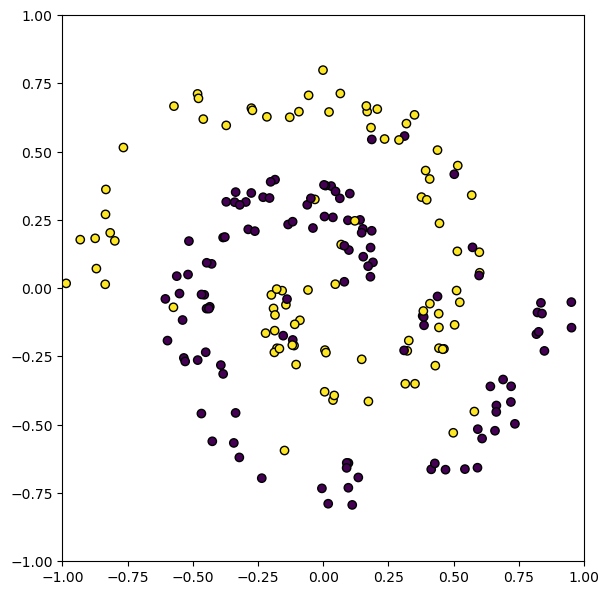

In [81]:
my_seed = 1 #int(random.random()*100000000)
np.random.seed(my_seed)
print("Seed used:", my_seed)

gen = sp.Spirals(sp.SpiralConf(2, 0.2, 0.1, 0.9, 1))
# gen = hm.HalfMoons([hm.HalfMoonConf(centre=(-0.2,-0.2), width=0.1, angle_range=(0,5.5)),
#                     hm.HalfMoonConf(centre=(0.2,0.2), width=0.1,angle_range=(3.14,3.14+5.5))])
#gen = cc.ConcentricBands()#[cc.CBandConf(0.7, 0.5)])
#gen = sb.RandomSeparatedBlobs()
gen.add_postprocesser(pp.LabelSwitch(labels=list(gen.labels.values()), noise_freq=0.1))
df = gen.sample(num_samples=200)

plt.figure(figsize=(6, 6))

colors = df['label'].astype("category").cat.codes
plt.scatter(df['x'], df['y'], c=colors, edgecolor='k')

plt.tight_layout()
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()

## Perceptrons

In [86]:
params = {
    'widths': list(map(lambda x: (2,)+(10,)*x+(2,), [16,8,4,1,0])),
    'activation': ["ReLU"],
    'optimizer': GDOptimizer(learning_rate=0.5)
}

tunable_model = TunableNN(
    hyperparameters=params
)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

num_batches = 5
training_params = {
    'num_epochs': 3000,
    'batch_size': (len(df)*train_split) // num_batches,
    'compute_metrics': True,
    'metrics_dict': {'accuracy': accuracy, 'loss': mean_squared_error}
}

title_generator = lambda params: f"Width: {params['widths']}"
encode_label = lambda ls: labels_encoding(ls.to_numpy())

measure_accuracy = lambda model, data: \
    accuracy(
        model.decision_function(data[['x', 'y']].to_numpy()), 
        encode_label(data['label'])
    )
    
configNN = ExperimentConfig(
    tunable_model=tunable_model,
    train_df=train_df,
    test_df=test_df,
    training_params=training_params,
    title_generator=title_generator,
    encode_label=encode_label,
    measure_accuracy=measure_accuracy,
    random_seed=5
)

Fitting 6 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done

All models trained. Collecting results...
Results collected.


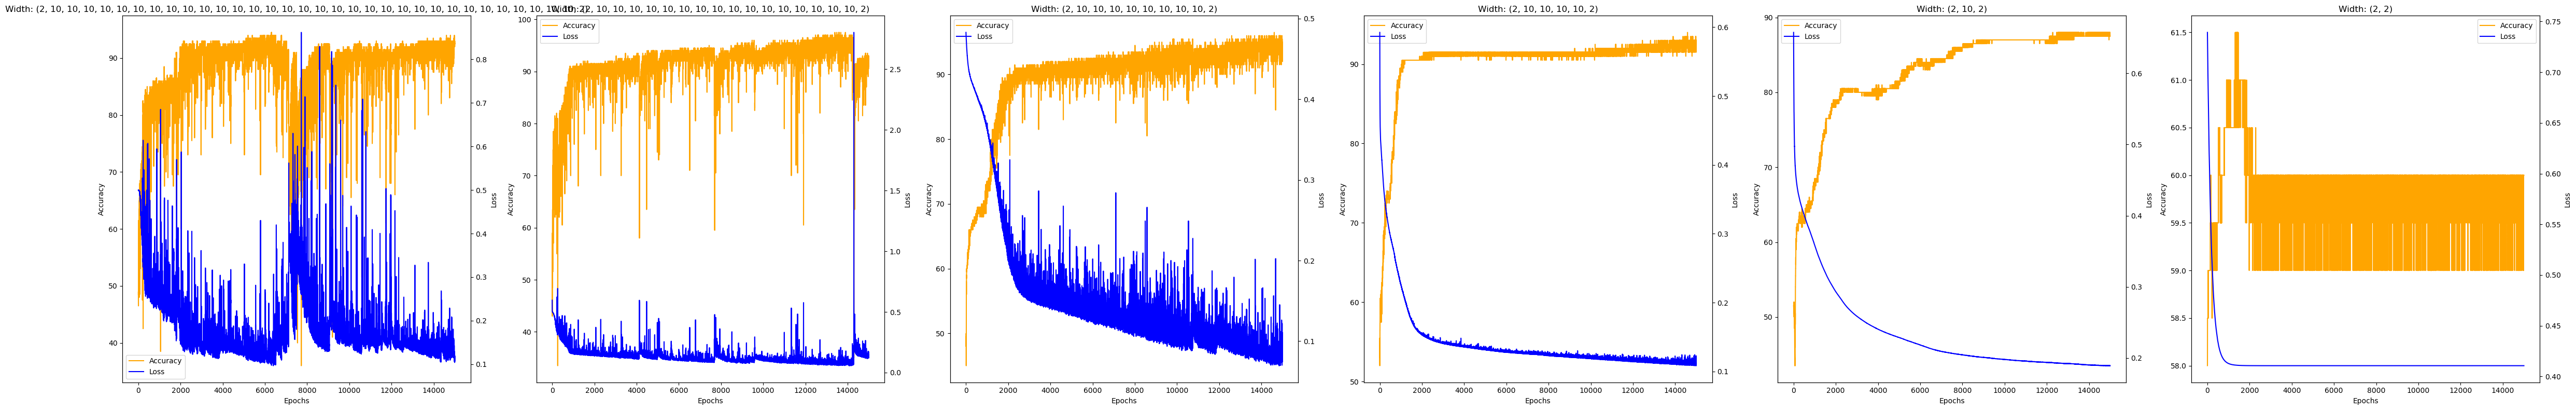

In [87]:
trained_models = train_tunable_model(configNN)

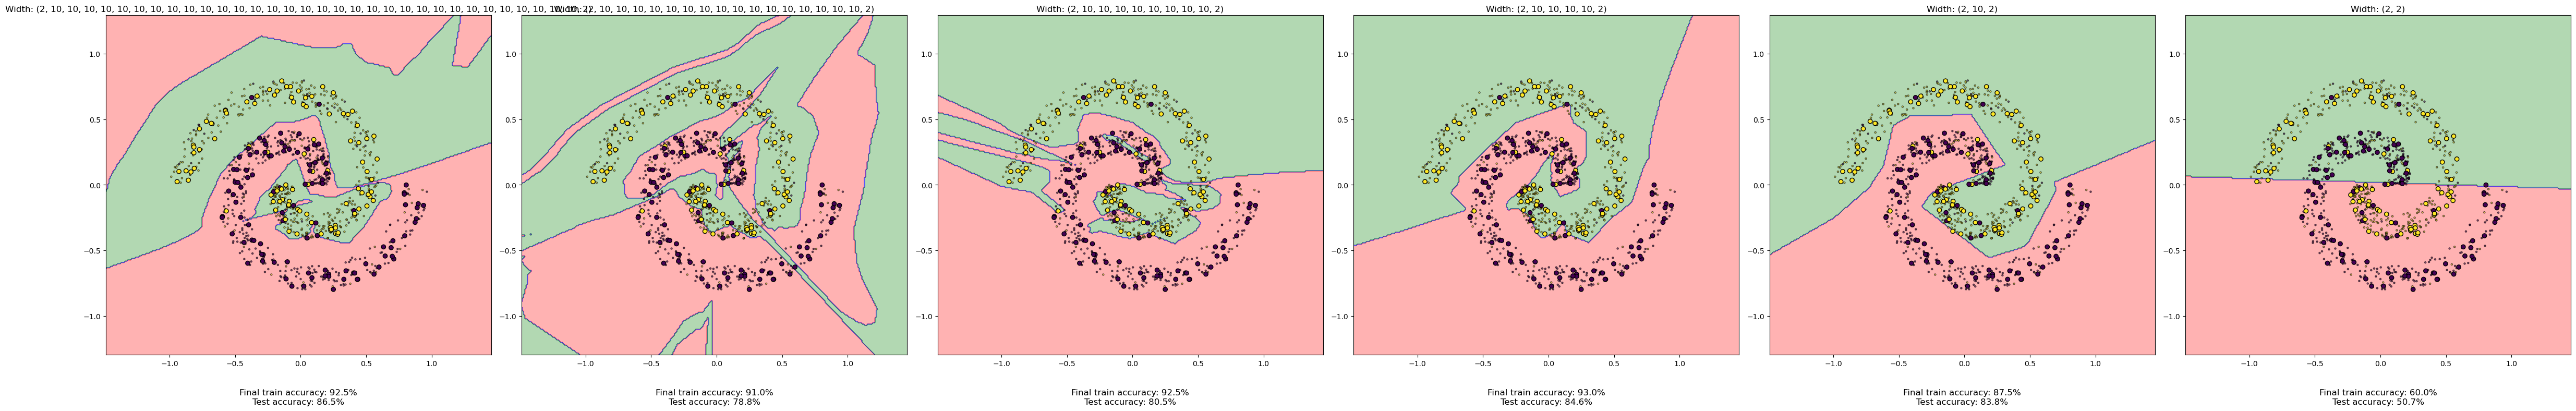

In [88]:
show_tunable_model(configNN, trained_models)

## Kernel SVM

In [54]:
params = {
    'kernel': ['rbf'],
    'sigma': [0.01,0.03,0.1,0.4,1],
    'degree': range(1),
    'intercept': range(3),
}

tunable_model = TunableKernelSVM(
    hyperparameters=params,
)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=2000),
    training_data_fraction=train_split,
    return_numpy=False
)

title_generator = lambda params: f"Sigma: {params['sigma']}"
encode_label = lambda ls: ls.astype("category").cat.codes.to_numpy() * 2 - 1

measure_accuracy = lambda model, data: \
    accuracy(
        model(data[['x', 'y']].to_numpy()), 
        encode_label(data['label']),
        one_hot_encoded_labels=False
    )
    
configSVM = ExperimentConfig(
    tunable_model=tunable_model,
    train_df=train_df,
    test_df=test_df,
    training_params=None,
    title_generator=title_generator,
    encode_label=encode_label,
    measure_accuracy=measure_accuracy,
    random_seed=1
)

In [55]:
trained_models = train_tunable_model(configSVM)

Fitting 5 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done

All models trained. Collecting results...
Results collected.


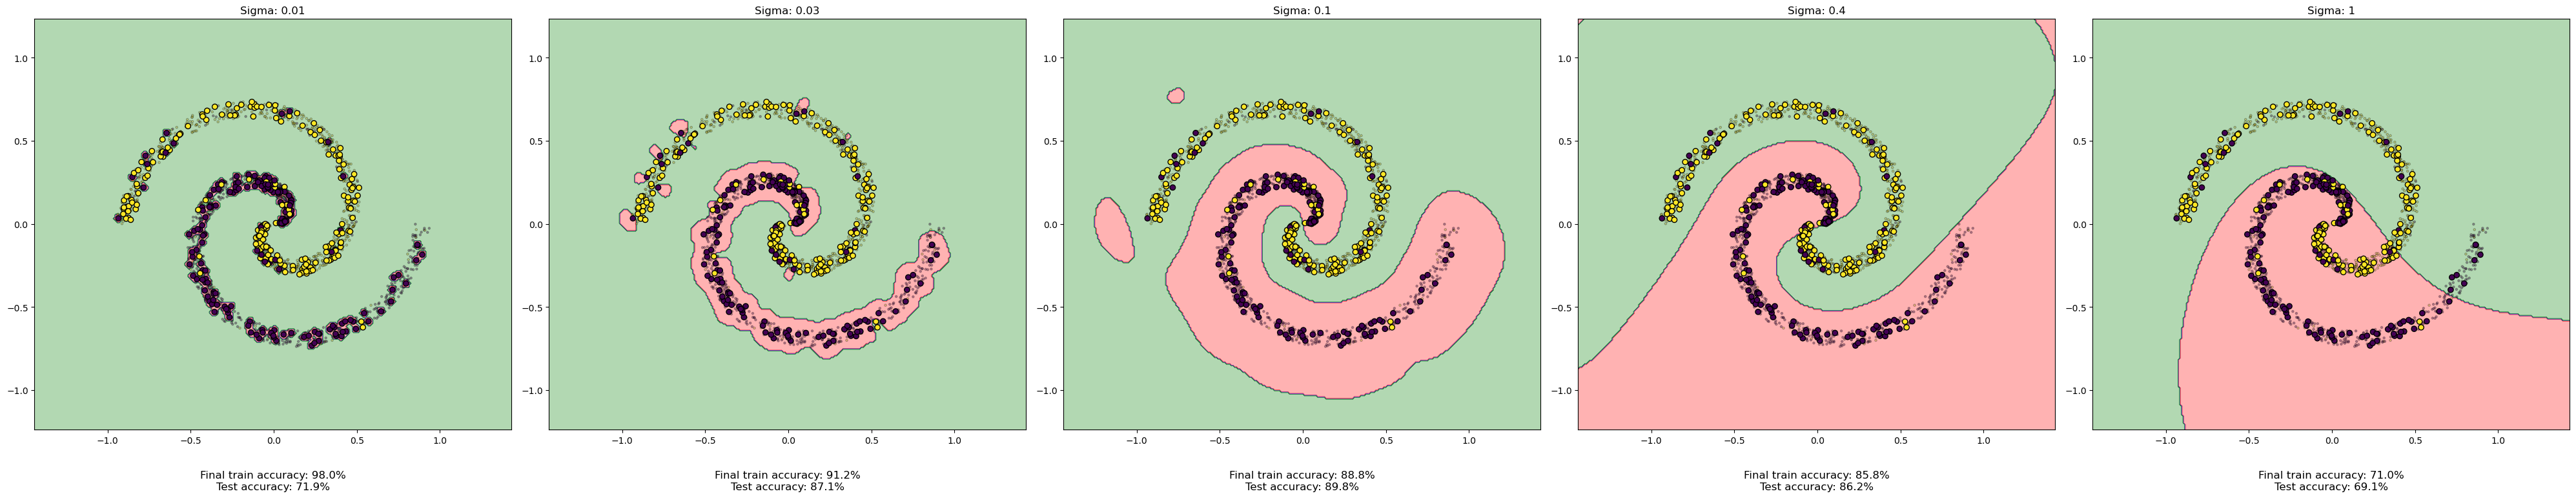

In [56]:
show_tunable_model(configSVM, trained_models)

## Decision Trees

In [76]:
params = {
    'n_estimators': [20],
    'max_depth': [1,2,4,8,16,32,64],
    'min_samples_split': 2,
    'max_features': None
}

tunable_model = TunableRandomForest(
    hyperparameters=params,
)

train_split = 0.2
df, train_df, test_df = train_test_split(
    gen.sample(num_samples=1000),
    training_data_fraction=train_split,
    return_numpy=False
)

title_generator = lambda params: f"Estimators: {params['n_estimators']}, Depth: {params['max_depth']}"
encode_label = lambda ls: ls.to_numpy()

measure_accuracy = lambda model, data: \
    accuracy(
        model.decision_function(data[['x', 'y']].to_numpy()), 
        encode_label(data['label']),
        one_hot_encoded_labels=False
    )
    
configTrees = ExperimentConfig(
    tunable_model=tunable_model,
    train_df=train_df,
    test_df=test_df,
    training_params=None,
    title_generator=title_generator,
    encode_label=encode_label,
    measure_accuracy=measure_accuracy,
    random_seed=1
)

In [77]:
trained_models = train_tunable_model(configTrees)

Fitting 7 models with 2 processes.
Model 0: Done | Model 1: Done | Model 2: Done | Model 3: Done | Model 4: Done | Model 5: Done | Model 6: Done

All models trained. Collecting results...
Results collected.


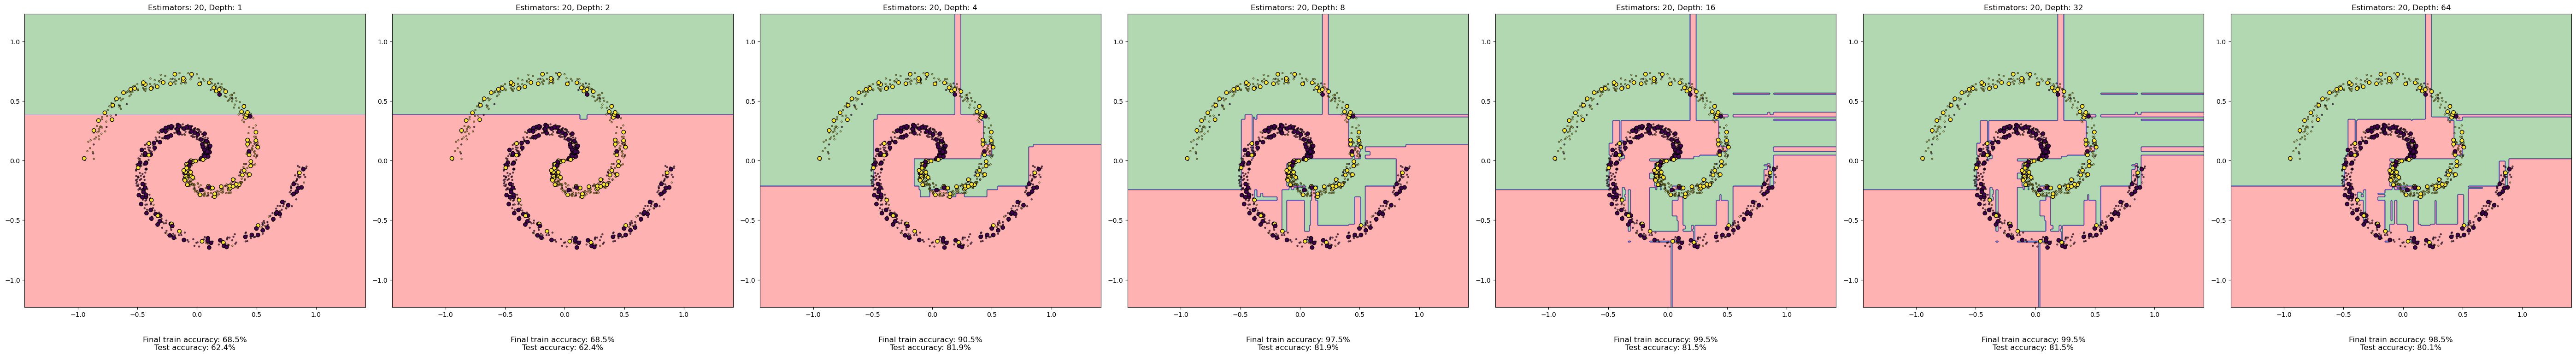

In [78]:
show_tunable_model(configTrees, trained_models)

## Final Analysis

In [ ]:
train_tunable_model()